# EfficientNetB7 Food Classification Model

This notebook implements a food classification model using EfficientNetB7 with the following features:
- Mixed precision training
- AdamW optimizer with optional Lookahead
- Label smoothing
- Dynamic learning rate reduction
- Model checkpointing

## Hardware Setup and GPU Check

In [1]:
!nvidia-smi

Tue Apr 22 20:34:47 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 572.16       CUDA Version: 12.8     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0  On |                  Off |
|  0%   40C    P0              53W / 495W |   1847MiB / 24564MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import Required Libraries

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import mixed_precision

# Try importing tensorflow-addons
try:
    import tensorflow_addons as tfa
    USE_LOOKAHEAD = True
    print("TensorFlow Addons found. Will use Lookahead optimizer.")
except ImportError:
    print("Warning: TensorFlow Addons not found (pip install tensorflow-addons).")
    print("Falling back to standard AdamW optimizer.")
    USE_LOOKAHEAD = False

2025-04-22 20:34:49.103033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745343289.196076    1097 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745343289.221097    1097 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745343289.422248    1097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745343289.422266    1097 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745343289.422267    1097 computation_placer.cc:177] computation placer alr

Falling back to standard AdamW optimizer.


/home/howweare/testing/.venv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/howweare/testing/.venv/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.19.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

## Configuration and Parameters

In [3]:
# Dataset paths
TRAIN_DIR = r"../new_food_ds/new_dataset/train"
TEST_DIR = r"../new_food_ds/new_dataset/test"
CLASS_NAMES_PATH = r"../new_food_ds/new_dataset/class_names.txt"

# Model paths
MODEL_SAVE_PATH = "./MODELS/refined_food_model_efficientnetb7_lookahead_adamw.keras"
BEST_CHECKPOINT_PATH = "./MODELS/best_food_model_b7_lookahead_checkpoint.keras"

# Training parameters
IMG_SIZE = 600
BATCH_SIZE = 16
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 30
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
WEIGHT_DECAY_INITIAL = 1e-5
WEIGHT_DECAY_FINETUNE = 1e-6
LABEL_SMOOTHING = 0.1
DROPOUT_RATE = 0.4

# Lookahead parameters
LOOKAHEAD_SYNC_PERIOD = 6
LOOKAHEAD_SLOW_STEP = 0.5

## Hardware Configuration

In [4]:
print("TensorFlow version:", tf.__version__)

# Configure CPU parallelism
num_cores = os.cpu_count()
print(f"CPU cores available: {num_cores}")
if num_cores:
    tf.config.threading.set_inter_op_parallelism_threads(num_cores)
    tf.config.threading.set_intra_op_parallelism_threads(num_cores)
    print("CPU parallelism configured.")

# Check for GPU and configure
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU devices available: {len(physical_devices)}")
    for device in physical_devices:
        print(f" - {device.name}")

    # Enable memory growth for GPUs
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}. Try restarting the kernel.")

    # Enable mixed precision training
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print(f"Mixed precision policy set to: {mixed_precision.global_policy().name}")
    except Exception as e:
        print(f"Warning: Could not set mixed precision: {e}")
        print("Continuing with default precision (float32).")
else:
    print("No GPU devices found. Running on CPU.")
    mixed_precision.set_global_policy('float32')
    print(f"Precision policy set to: {mixed_precision.global_policy().name}")

TensorFlow version: 2.19.0
CPU cores available: 12
CPU parallelism configured.
GPU devices available: 1
 - /physical_device:GPU:0
Memory growth enabled for GPUs.
Mixed precision policy set to: mixed_float16


## Data Preparation

In [5]:
# Load class names
try:
    with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
        class_names = [line.strip() for line in f.readlines()]
    num_classes = len(class_names)
    print(f"Found {num_classes} classes.")
except FileNotFoundError:
    print(f"Error: Class names file not found at {CLASS_NAMES_PATH}")
    print("Please update the CLASS_NAMES_PATH variable.")
    exit()

# Data generators setup
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

print("Creating train generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nCreating test generator...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nVerifying class indices:")
print("Class Indices (Train):", train_generator.class_indices)
print("Class Indices (Test):", test_generator.class_indices)

Found 149 classes.
Creating train generator...
Found 87161 images belonging to 149 classes.

Creating test generator...
Found 22806 images belonging to 149 classes.

Verifying class indices:
Class Indices (Train): {'Areeka(Yemen)': 0, 'Aseeda(Yemen)': 1, 'Balaleet(Qatar)': 2, 'EshAsaraya(Qatar)': 3, 'Fahsa(Yemen)': 4, 'GersOgaily(Kuwait)': 5, 'Harees(Qatar)': 6, 'Harissah(Yemen)': 7, 'Lahooh(Yemen)': 8, 'Luqaimat(Qatar)': 9, 'Malooga(Yemen)': 10, 'Mandi(Yemen)': 11, 'Maraq(Yemen)': 12, 'Margoog(Qatar)': 13, 'Markook(KSA)': 14, 'Martabak(Yemen)': 15, 'Masoub(Yemen)': 16, 'Mathrooba-Madrooba(Qatar-Oman)': 17, 'Megalgel(Yemen)': 18, 'Mehalabiya(Qatar)': 19, 'Mishkak(Oman)': 20, 'Mumawwash(Kuwait)': 21, 'MutabbaqSamaq(Kuwait)': 22, 'OmaniHalwa(Oman)': 23, 'Saleeg(KSA)': 24, 'Shafuut(Yemen)': 25, 'Shakshuka(yemen)': 26, 'Thareed(Qatar-KSA)': 27, 'UmmAli(Qatar)': 28, 'Zhoug(Yemen)': 29, 'apple_pie': 30, 'baby_back_ribs': 31, 'baklava': 32, 'beef_carpaccio': 33, 'beef_tartare': 34, 'beet_sala

## Model Building

In [6]:
def build_model(num_classes, img_size=600, dropout_rate=0.4):
    inputs = Input(shape=(img_size, img_size, 3))
    base_model = EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(dropout_rate, name="top_dropout")(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name="predictions")(x)

    model = Model(inputs, outputs)
    return model, base_model

# Build the initial model
model, base_model = build_model(num_classes, IMG_SIZE, DROPOUT_RATE)

# Define optimizers and compile model
base_optimizer_initial = AdamW(learning_rate=INITIAL_LR, weight_decay=WEIGHT_DECAY_INITIAL)

if USE_LOOKAHEAD:
    print("Using Lookahead(AdamW) for initial training.")
    optimizer_initial = tfa.optimizers.Lookahead(
        base_optimizer_initial,
        sync_period=LOOKAHEAD_SYNC_PERIOD,
        slow_step_size=LOOKAHEAD_SLOW_STEP
    )
else:
    print("Using standard AdamW for initial training.")
    optimizer_initial = base_optimizer_initial

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)

model.compile(optimizer=optimizer_initial,
            loss=loss_fn,
            metrics=['accuracy'])

print("\n--- Initial Model Summary (Base Frozen) ---")
model.summary()

I0000 00:00:1745343297.768661    1097 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Using standard AdamW for initial training.

--- Initial Model Summary (Base Frozen) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 600, 600,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 600, 600,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 600, 600,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 600, 600,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 601, 601,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 300, 300,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 300, 300,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 300, 300,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 300, 300,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 300, 300,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 300, 300,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 300, 300,  │          0 │ block1a_activati

 Total params: 66,872,876 (255.10 MB)

 Trainable params: 2,775,189 (10.59 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

## Training Setup and Callbacks

In [7]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

model_checkpoint = ModelCheckpoint(
    filepath=BEST_CHECKPOINT_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# Calculate steps
steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, test_generator.samples // BATCH_SIZE)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 5447
Validation steps: 1425


## Initial Training Phase

In [8]:
print("\n--- Starting Initial Training (Feature Extraction) ---")
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

end_time = time.time()
print(f"Initial training time: {end_time - start_time:.2f} seconds")


--- Starting Initial Training (Feature Extraction) ---


/home/howweare/testing/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1745343318.425856    1240 service.cc:152] XLA service 0x7f6afc0039d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745343318.425880    1240 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-22 20:35:19.158883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745343321.842437    1240 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-22 20:35:25.379166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43005', 524 bytes spill stores, 524 bytes spill loads

2025-04-22 20:35:25.389031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41

   2/5447 ━━━━━━━━━━━━━━━━━━━━ 6:49 75ms/step - accuracy: 0.0000e+00 - loss: 5.0617   

I0000 00:00:1745343342.982881    1240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 338/5447 ━━━━━━━━━━━━━━━━━━━━ 42:23 498ms/step - accuracy: 0.1106 - loss: 4.6409

/home/howweare/testing/.venv/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2243/5447 ━━━━━━━━━━━━━━━━━━━━ 26:35 498ms/step - accuracy: 0.3290 - loss: 3.5356

2025-04-22 20:54:25.081306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41626', 164 bytes spill stores, 164 bytes spill loads

2025-04-22 20:54:25.121066: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41626', 1016 bytes spill stores, 1016 bytes spill loads

2025-04-22 20:54:25.294492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41626', 16 bytes spill stores, 16 bytes spill loads

2025-04-22 20:54:25.569620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42929', 224 bytes spill stores, 224 bytes spill loads

2025-04-22 20:54:25.598938: 

5447/5447 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.4344 - loss: 3.0159

2025-04-22 21:21:20.266607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7589', 244 bytes spill stores, 244 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.66715, saving model to ./MODELS/best_food_model_b7_lookahead_checkpoint.keras
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 2895s 524ms/step - accuracy: 0.4344 - loss: 3.0158 - val_accuracy: 0.6671 - val_loss: 2.0122 - learning_rate: 1.0000e-04
Epoch 2/50
   1/5447 ━━━━━━━━━━━━━━━━━━━━ 7:39 84ms/step - accuracy: 0.9375 - loss: 1.4069

/home/howweare/testing/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.66715
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 119s 22ms/step - accuracy: 0.9375 - loss: 1.4069 - val_accuracy: 0.6668 - val_loss: 2.0126 - learning_rate: 1.0000e-04
Epoch 3/50
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6560 - loss: 2.0528
Epoch 3: val_accuracy improved from 0.66715 to 0.70965, saving model to ./MODELS/best_food_model_b7_lookahead_checkpoint.keras
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 2774s 509ms/step - accuracy: 0.6560 - loss: 2.0528 - val_accuracy: 0.7096 - val_loss: 1.8751 - learning_rate: 1.0000e-04
Epoch 4/50
   1/5447 ━━━━━━━━━━━━━━━━━━━━ 5:51 65ms/step - accuracy: 0.8125 - loss: 1.5235
Epoch 4: val_accuracy did not improve from 0.70965
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 100s 18ms/step - accuracy: 0.8125 - loss: 1.5235 - val_accuracy: 0.7093 - val_loss: 1.8761 - learning_rate: 1.0000e-04
Epoch 5/50
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6931 - loss: 1.9355
Epoch 5: val_accuracy improved from 0.70965 to 

## Fine-tuning Phase

In [9]:
print("\n--- Setting up for Fine-tuning ---")
base_model.trainable = True

fine_tune_at = -20
print(f"Attempting to unfreeze layers from layer index: {fine_tune_at}")
print(f"Total layers in base model: {len(base_model.layers)}")

if abs(fine_tune_at) > len(base_model.layers):
    print(f"Warning: fine_tune_at ({fine_tune_at}) adjusted to unfreeze all layers.")
    fine_tune_at = 0

actual_fine_tune_layer_index = len(base_model.layers) + fine_tune_at if fine_tune_at < 0 else fine_tune_at

for i, layer in enumerate(base_model.layers):
    if i < actual_fine_tune_layer_index:
        layer.trainable = False
    else:
        layer.trainable = True

# Define the base AdamW optimizer for fine-tuning
base_optimizer_finetune = AdamW(learning_rate=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY_FINETUNE)

if USE_LOOKAHEAD:
    print("Using Lookahead(AdamW) for fine-tuning.")
    optimizer_finetune = tfa.optimizers.Lookahead(
        base_optimizer_finetune,
        sync_period=LOOKAHEAD_SYNC_PERIOD,
        slow_step_size=LOOKAHEAD_SLOW_STEP
    )
else:
    print("Using standard AdamW for fine-tuning.")
    optimizer_finetune = base_optimizer_finetune

model.compile(optimizer=optimizer_finetune,
            loss=loss_fn,
            metrics=['accuracy'])

print("\n--- Fine-tuning Model Summary ---")
model.summary()
print(f"Number of trainable variables: {len(model.trainable_variables)}")


--- Setting up for Fine-tuning ---
Attempting to unfreeze layers from layer index: -20
Total layers in base model: 814
Using standard AdamW for fine-tuning.

--- Fine-tuning Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 600, 600,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 600, 600,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 600, 600,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 600, 600,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 601, 601,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 300, 300,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 300, 300,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 300, 300,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 300, 300,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 300, 300,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 300, 300,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 300, 300,  │          0 │ block1a_activati

 Total params: 66,872,876 (255.10 MB)

 Trainable params: 10,617,909 (40.50 MB)

 Non-trainable params: 56,254,967 (214.60 MB)

Number of trainable variables: 20


In [10]:
print("\n--- Starting Fine-tuning ---")
start_time_ft = time.time()

initial_epoch_ft = history.epoch[-1] + 1 if history.epoch else 0
total_epochs = initial_epoch_ft + FINE_TUNE_EPOCHS

print(f"Fine-tuning from epoch {initial_epoch_ft} to {total_epochs -1}")

fine_tune_history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=initial_epoch_ft,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

end_time_ft = time.time()
print(f"Fine-tuning time: {end_time_ft - start_time_ft:.2f} seconds")


--- Starting Fine-tuning ---
Fine-tuning from epoch 50 to 79
Epoch 51/80
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8048 - loss: 1.5803
Epoch 51: val_accuracy improved from 0.79132 to 0.80140, saving model to ./MODELS/best_food_model_b7_lookahead_checkpoint.keras
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 2833s 514ms/step - accuracy: 0.8048 - loss: 1.5803 - val_accuracy: 0.8014 - val_loss: 1.5718 - learning_rate: 1.0000e-05
Epoch 52/80
   1/5447 ━━━━━━━━━━━━━━━━━━━━ 6:00 66ms/step - accuracy: 0.7500 - loss: 1.4681
Epoch 52: val_accuracy improved from 0.80140 to 0.80145, saving model to ./MODELS/best_food_model_b7_lookahead_checkpoint.keras
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 96s 18ms/step - accuracy: 0.7500 - loss: 1.4681 - val_accuracy: 0.8014 - val_loss: 1.5718 - learning_rate: 1.0000e-05
Epoch 53/80
5447/5447 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8240 - loss: 1.5098
Epoch 53: val_accuracy improved from 0.80145 to 0.80732, saving model to ./MODELS/best_food_model_b7_lookah

## Model Evaluation

In [11]:
print("\n--- Evaluating Final Model ---")
if os.path.exists(BEST_CHECKPOINT_PATH):
    print(f"Loading best model from checkpoint: {BEST_CHECKPOINT_PATH}")
    custom_objects = {}
    if USE_LOOKAHEAD:
        custom_objects['Lookahead'] = tfa.optimizers.Lookahead
        custom_objects['AdamW'] = AdamW

    try:
        model = tf.keras.models.load_model(BEST_CHECKPOINT_PATH, custom_objects=custom_objects, compile=True)
        print("Best model loaded successfully.")
    except Exception as e:
        print(f"Error loading model from checkpoint: {e}")
        print("Evaluating the model state after fine-tuning instead.")
        if not model.optimizer:
            model.compile(optimizer=optimizer_finetune, loss=loss_fn, metrics=['accuracy'])
else:
    print(f"Warning: Best checkpoint file not found at {BEST_CHECKPOINT_PATH}.")
    print("Evaluating the model state after fine-tuning.")
    if not model.optimizer:
        model.compile(optimizer=optimizer_finetune, loss=loss_fn, metrics=['accuracy'])

final_loss, final_acc = model.evaluate(test_generator, steps=validation_steps)
print(f"\nFinal Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_acc:.4f}")

# Save the final model
print(f"\nSaving final model to: {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")


--- Evaluating Final Model ---
Loading best model from checkpoint: ./MODELS/best_food_model_b7_lookahead_checkpoint.keras
Best model loaded successfully.
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 108s 69ms/step - accuracy: 0.8488 - loss: 1.4293

Final Test Loss: 1.4656
Final Test Accuracy: 0.8350

Saving final model to: ./MODELS/refined_food_model_efficientnetb7_lookahead_adamw.keras
Model saved successfully.


## Training Visualization

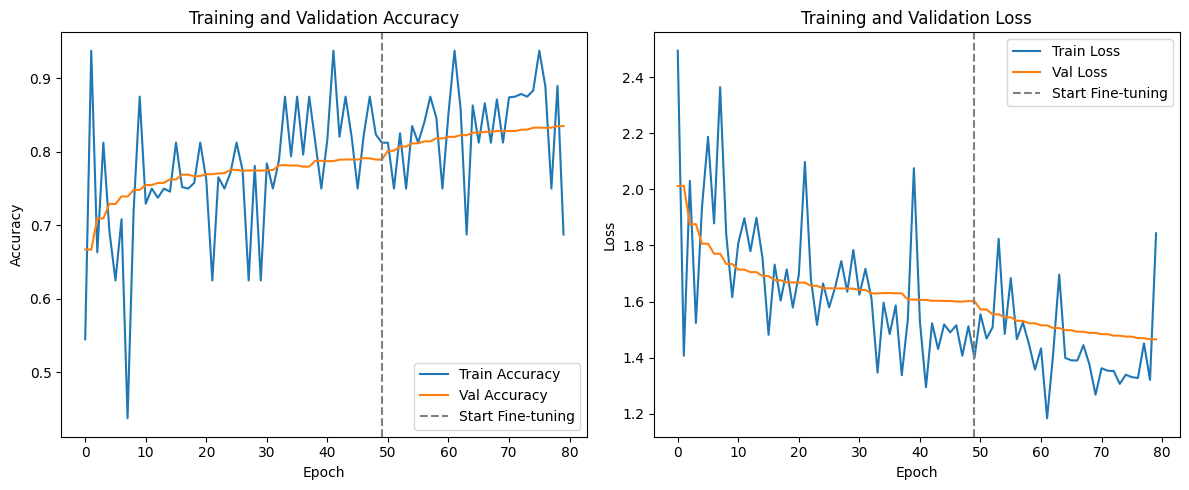


--- Training Complete ---


In [12]:
def plot_history(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    initial_epochs = 0
    if histories and histories[0] and histories[0].history:
        initial_epochs = len(histories[0].epoch)

    for h in histories:
        if h and h.history:
            acc += h.history.get('accuracy', [])
            val_acc += h.history.get('val_accuracy', [])
            loss += h.history.get('loss', [])
            val_loss += h.history.get('val_loss', [])
        else:
            print("Warning: A history object was empty or None, skipping.")

    if not acc:
        print("No history data to plot.")
        return

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    if len(histories) > 1 and initial_epochs > 0:
        plt.axvline(initial_epochs - 1, color='grey', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    if len(histories) > 1 and initial_epochs > 0:
        plt.axvline(initial_epochs - 1, color='grey', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# Plot combined history
plot_history([history, fine_tune_history])

print("\n--- Training Complete ---")

## Confusion Matrix and F1 Score Analysis

Generating predictions for test data...
 111/1425 ━━━━━━━━━━━━━━━━━━━━ 2:28 113ms/step

/home/howweare/testing/.venv/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 117s 77ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 117s 77ms/step


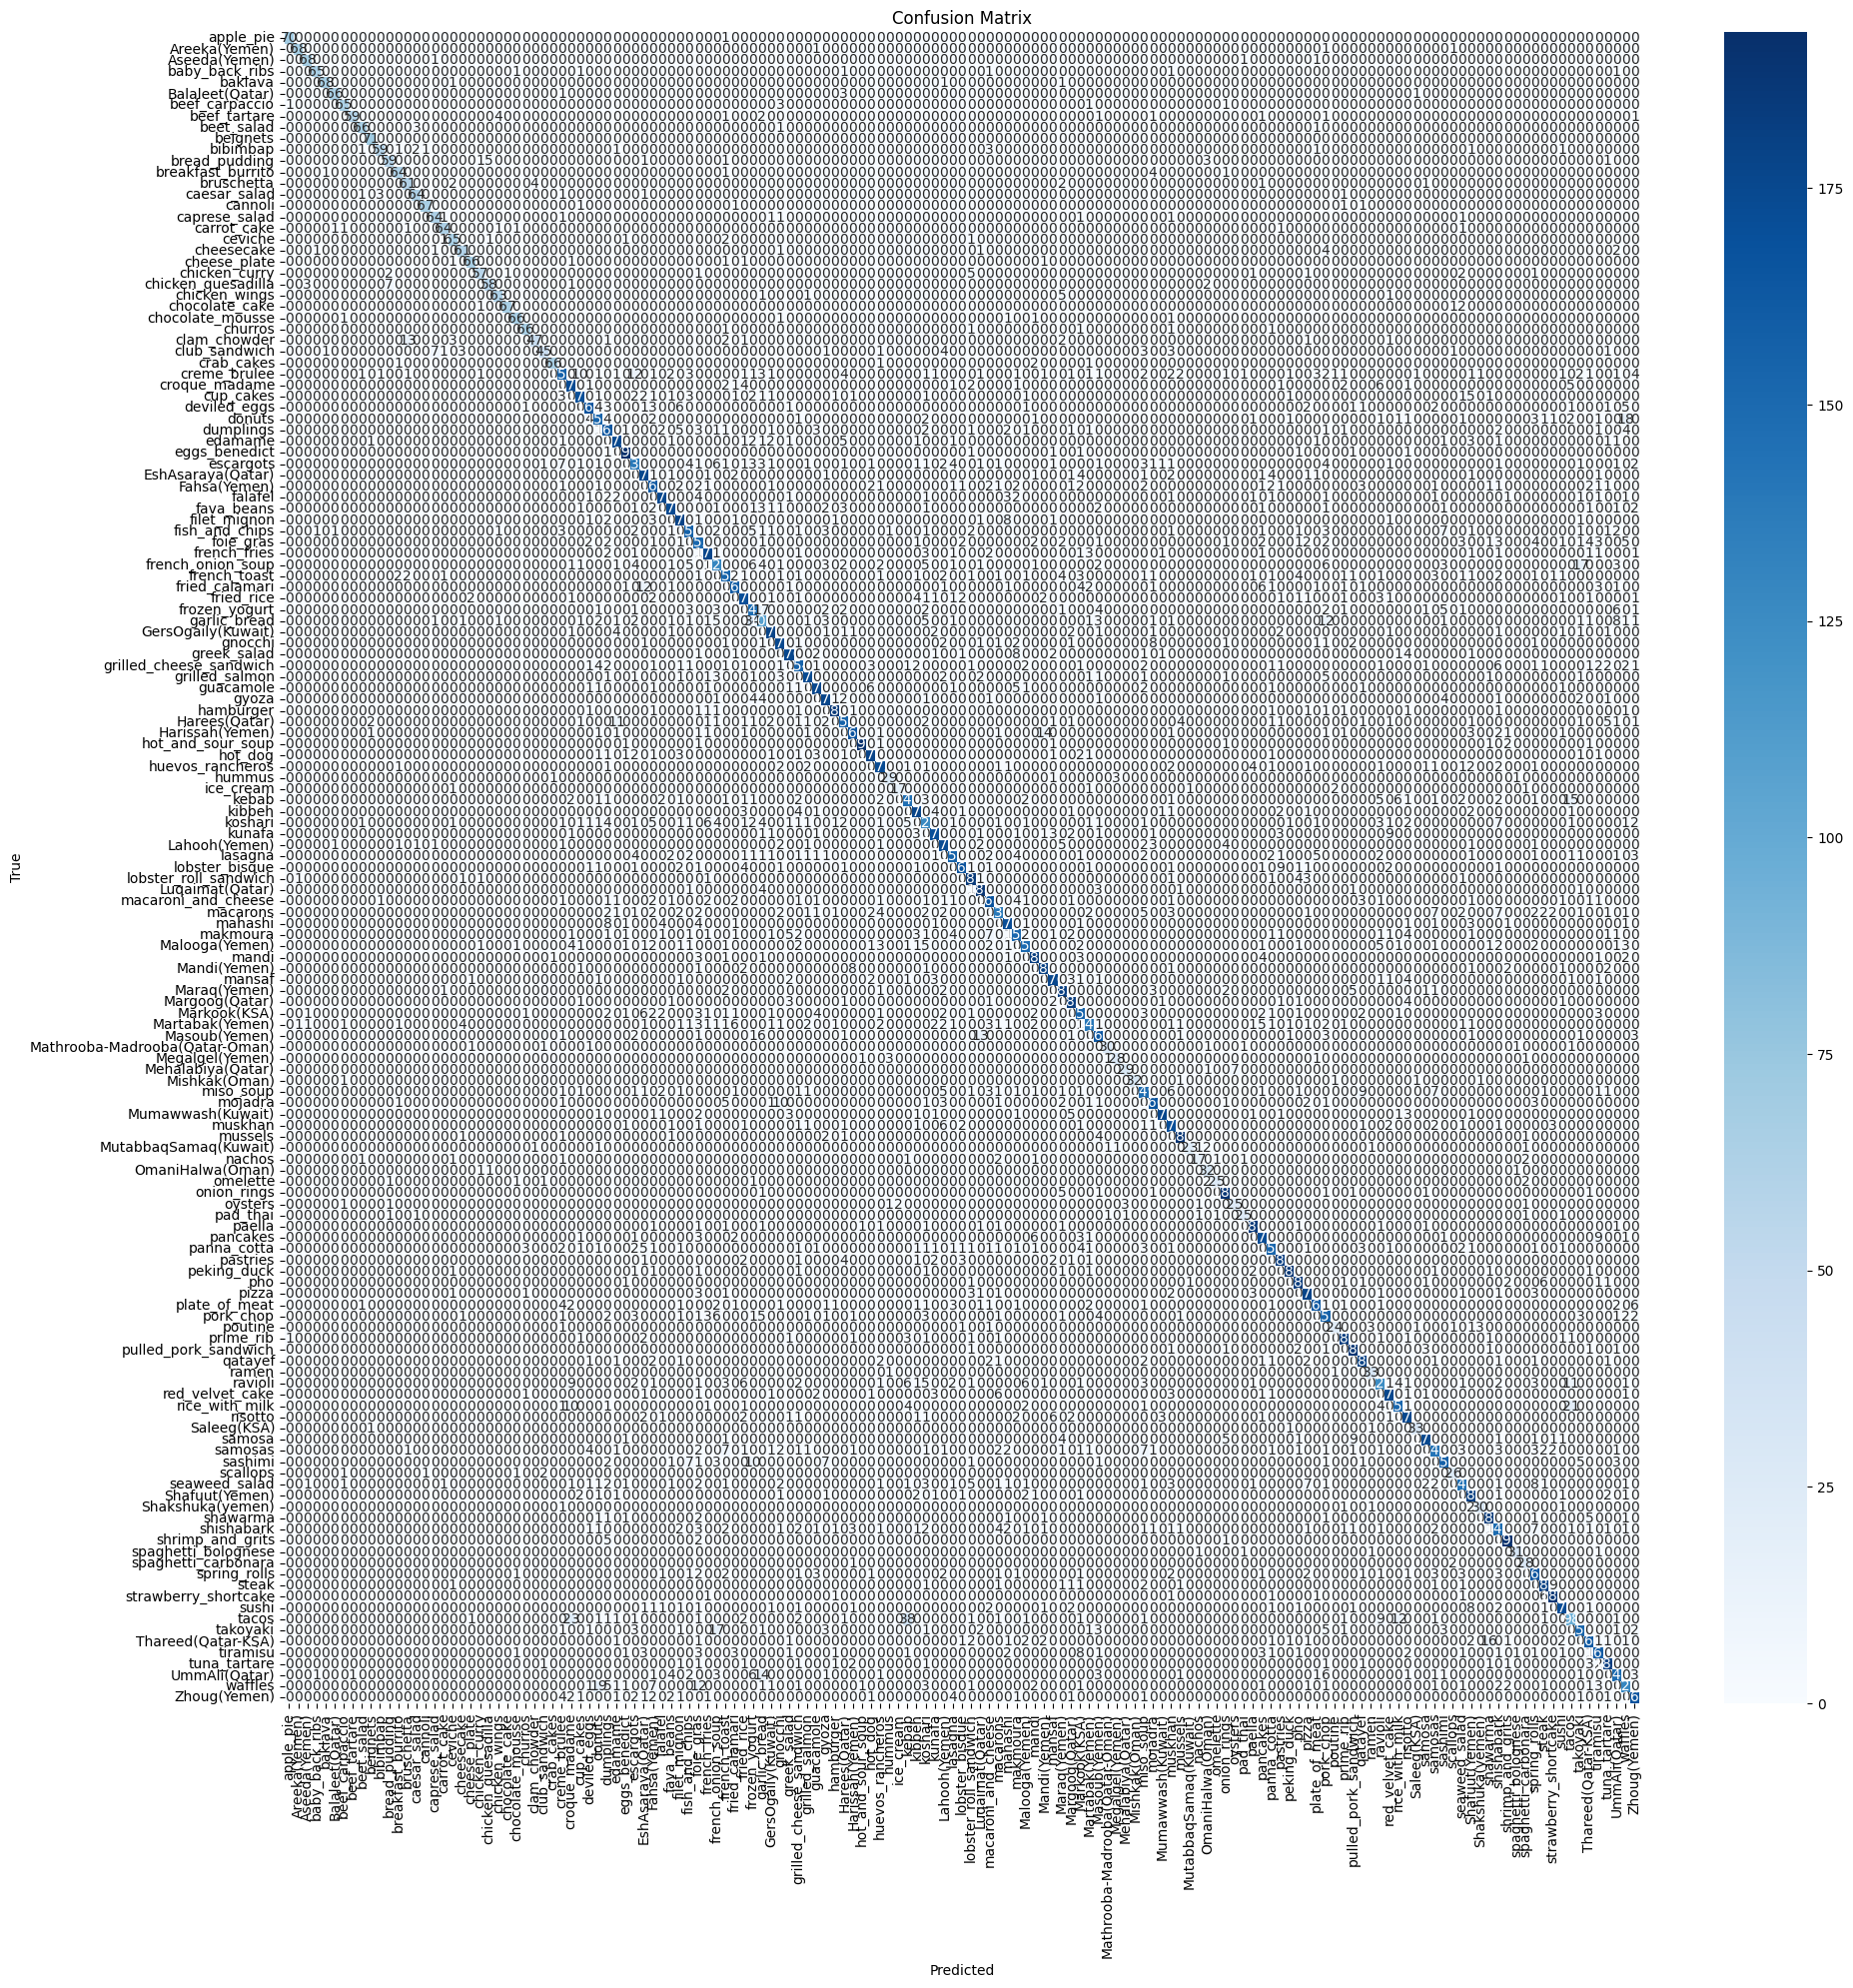


Classification Report:
                                precision    recall  f1-score   support

                     apple_pie     0.9722    0.9859    0.9790        71
                 Areeka(Yemen)     0.9714    0.9577    0.9645        71
                 Aseeda(Yemen)     0.9189    0.9577    0.9379        71
                baby_back_ribs     0.9559    0.9155    0.9353        71
                       baklava     0.9714    0.9577    0.9645        71
               Balaleet(Qatar)     0.9565    0.9296    0.9429        71
                beef_carpaccio     0.9028    0.9155    0.9091        71
                  beef_tartare     0.9833    0.8310    0.9008        71
                    beet_salad     0.9167    0.9296    0.9231        71
                      beignets     0.9342    1.0000    0.9660        71
                      bibimbap     0.9219    0.8310    0.8741        71
                 bread_pudding     0.8310    0.8310    0.8310        71
             breakfast_burrito     0.88

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Reset the generator to ensure we process all samples
test_generator.reset()

# Get predictions
print("Generating predictions for test data...")
y_pred = model.predict(test_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes[:len(y_pred_classes)]

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate and display classification report
print("\nClassification Report:")
report = classification_report(y_true, y_pred_classes,
                             target_names=class_names,
                             digits=4)
print(report)

# Calculate overall F1 Score
overall_f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"\nOverall Weighted F1 Score: {overall_f1:.4f}")

# Get top-5 and bottom-5 performing classes based on F1 score
class_f1_scores = f1_score(y_true, y_pred_classes, average=None)
class_performance = list(zip(class_names, class_f1_scores))
class_performance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 performing classes (F1 Score):")
for class_name, f1 in class_performance[:5]:
    print(f"{class_name}: {f1:.4f}")

print("\nBottom 5 performing classes (F1 Score):")
for class_name, f1 in class_performance[-5:]:
    print(f"{class_name}: {f1:.4f}")